In [9]:
import folium  # For interactive maps
from folium.plugins import HeatMap
import pandas as pd
import geopandas as gpd  # For handling geospatial data
import numpy as np
import matplotlib.pyplot as plt  # For static visualizations
import seaborn as sns #For bar graphs

In [10]:
#Load data
df = pd.read_csv('Pittsburgh_Parking.csv')

#Rename Columns
df.rename(columns={'y': 'ORIGIN_LAT', 'x': 'ORIGIN_LON'}, inplace=True)

# Plot using Matplotlib (static map)
#df[['ORIGIN_LAT', 'ORIGIN_LON']].plot(kind="scatter", x="ORIGIN_LON", y="ORIGIN_LAT", figsize=(10, 6))
#plt.show()
#Clean columns
df = df.dropna(subset=['ORIGIN_LAT', 'ORIGIN_LON'])

#Clean the rate column (so it can be used for bubble + heat map)
df['rate_clean'] = df['rate'].str.extract(r'(\d+)')
df['rate_clean'] = pd.to_numeric(df['rate_clean'], errors='coerce')

#Color function to assign the bubbles a color
def get_color(rate):
    if rate <= 1:
        return "green"
    elif rate <= 3:
        return "yellow"
    elif rate <= 4:
        return "red"
    else:
        return None

#Find the middle point for the map
m = folium.Map(location=[df['ORIGIN_LAT'].mean(), df['ORIGIN_LON'].mean()], zoom_start=14, tiles='CartoDB positron')

#Add all of the bubbles to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['ORIGIN_LAT'], row['ORIGIN_LON']],
        radius=4,
        color=get_color(row['rate_clean']),
        fill=True,
        fill_color=get_color(row['rate_clean']),
        fill_opactiy=0.5,
        popup=f"Parking Location: {row.get('location', 'Unknown')}<br>Rate: ${row['rate_clean']:2f} Per Hour", 
        tooltip = f"${row['rate_clean']:2f} Per Hour"
    ).add_to(m)

legend_html = """
<div style="
    position: fixed; 
    bottom: 15px; right: 15px; width: 160px; height: 130px; 
    background-color: white; 
    border:2px solid grey; 
    z-index:9999;
    font-size:14px;
    padding: 10px;
    ">
    <b>Parking Rate Legend</b><br>
    <i style="background:green; width:10px; height:10px; display:inline-block;"></i> $0–1 per hr<br>
    <i style="background:yellow; width:10px; height:10px; display:inline-block;"></i> $1.01–3 per hr<br>
    <i style="background:red; width:10px; height:10px; display:inline-block;"></i> $3.01–4 per hr<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m

In [11]:
#Price values from 0 to 1 so it can be used for the heat map
min_price = df['rate_clean'].min()
max_price = df['rate_clean'].max()
df['rate_weight'] = (df['rate_clean'] - min_price) / (max_price - min_price)

#Find the data for the heat map and then add it
heat_data = df[['ORIGIN_LAT', 'ORIGIN_LON', 'rate_clean']].dropna().values.tolist()
m = folium.Map(location=[df['ORIGIN_LAT'].mean(), df['ORIGIN_LON'].mean()], zoom_start=14, tiles='CartoDB positron')
HeatMap(heat_data, min_opacity=0.5, max_zoom=13, radius=15, blur=10).add_to(m)
m

In [12]:
unique_parking_areas = df[['ORIGIN_LAT', 'ORIGIN_LON']].drop_duplicates().shape[0]
print(f"Unique parking areas: {unique_parking_areas}")

Unique parking areas: 1026


C:\Users\Medusa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


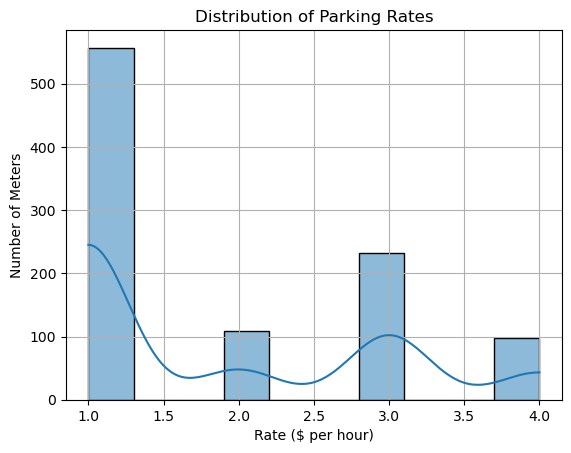

In [13]:
sns.histplot(df['rate_clean'], bins=10, kde=True)
plt.title('Distribution of Parking Rates')
plt.xlabel('Rate ($ per hour)')
plt.ylabel('Number of Meters')
plt.grid(True)
plt.show()

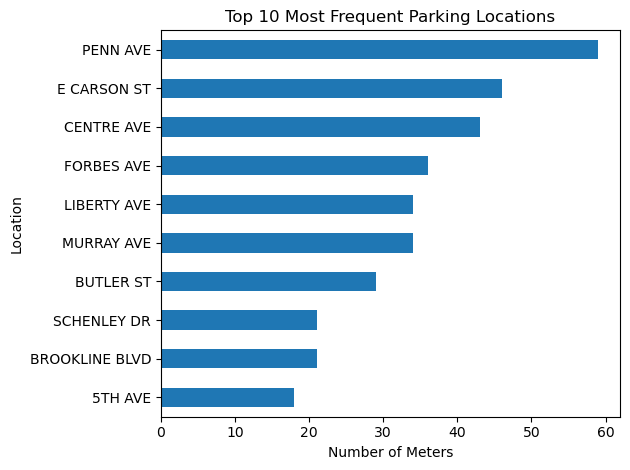

In [17]:
top_locations = df['location'].value_counts().head(10)

top_locations.plot(kind='barh')
plt.title('Top 10 Most Frequent Parking Locations')
plt.xlabel('Number of Meters')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()